# Установка зависимостей и загрузка LFW

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import os
import tensorflow as tf
import tensorflow_datasets as tfds
!pip install face_recognition
import face_recognition
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.8.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Загрузка датасета

In [ ]:
ds, info= tfds.load('lfw', split=(['train[:75%]','train[75%:]']),shuffle_files=True,
    as_supervised=True,with_info=True)



info.features['label']

# Подготовка тренировочной части датасета

In [ ]:
df=tfds.as_dataframe(ds[0],info) 
dict_label=df['label'].value_counts().reset_index()
num_class=dict_label.shape[0]
num_class



df['class']=0
for i in range(0, len(df)):
    df.loc[i,'class']=dict_label[dict_label['index']==df['label'][i]].index.values[0]

print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

train_df=df.copy()
test_df=df

num_class=50
train_df=train_df[df['label'].isin(dict_label[:num_class]['index'])]
train_df.shape

# Подготовка тестовой части датасета

In [ ]:
df_test=tfds.as_dataframe(ds[0],info) 
dict_label=df_test['label'].value_counts().reset_index()
num_class_test=dict_label.shape[0]
num_class_test


df_test['class']=0
for i in range(0, len(df)):
    df.loc[i,'class']=dict_label[dict_label['index']==df_test['label'][i]].index.values[0]

print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

train_df_test=df_test.copy()
df_test=df


num_class=50
train_df_test=train_df_test[df_test['label'].isin(dict_label[:num_class]['index'])]
train_df_test.shape

# Вспомогательные функций для работы веб-камеры в Google Colab

In [ ]:
# import dependencies

ar_emb=[]
ar_names=[]  
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: green; font-weight: bold;">';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Получение снимка лица

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


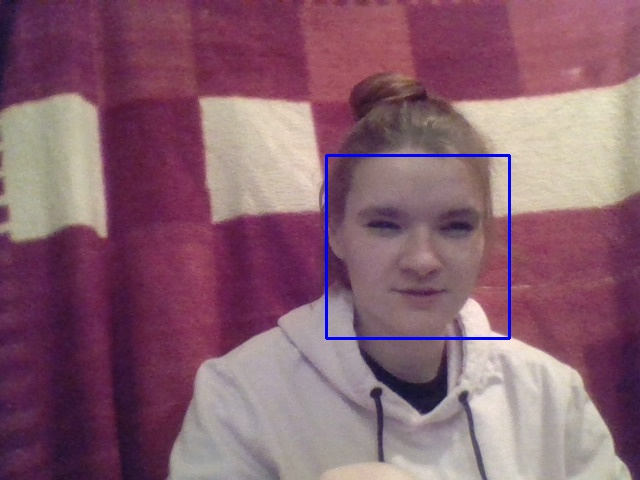

Enter the Name:Lisa


In [ ]:
str_name=[]
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  picture_of_me = face_recognition.load_image_file("photo.jpg")
  my_face_encoding = face_recognition.face_encodings(picture_of_me)[0]

  
  # Show the image which was just taken.
  display(Image(filename))
  str_name = input('Enter the Name:')
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
finally:
  if len(str_name)>0:
    ar_names +=[str_name]
    ar_emb +=[my_face_encoding]



# Формирование модели идентификатора

In [ ]:
# start streaming video from webcam
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    ramka = np.zeros([480,640,4], dtype=np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    faces = face_cascade.detectMultiScale(gray)

    for (x,y,w,h) in faces:
      bbox_array = img[y:y+h,x:x+w,:]
      unknown_face_encoding = face_recognition.face_encodings(bbox_array.astype('uint8'))
      #функция идентификатора сюда
      if len(unknown_face_encoding)>0:
         results = face_recognition.compare_faces(ar_emb, unknown_face_encoding[0],tolerance=0.6)
         


         if sum(results) > 0:
           k=np.where(results)[0]
           s=ar_names[k[0]]

         else:
           s="Unknown user"

    

      
      ramka = cv2.rectangle(ramka,(x,y),(x+w,y+h),(255,0,0),2)
      ramka=cv2.putText(ramka,s,(x,y),cv2.FONT_ITALIC,1,(255,255,255),4)
    ramka[:,:,3] = (ramka.max(axis = 2) > 0 ).astype(int) * 255

    bbox_bytes = bbox_to_bytes(ramka)

    bbox = bbox_bytes


<IPython.core.display.Javascript object>

In [ ]:
def neur_par(X):

    k1,k2,k3,emb,marg,batch,num_ep,learn_rate=X
        
   
    optimizer = tf.keras.optimizers.Adam(learn_rate)
        
    def contastive_loss(embs, labels):
       # print(embs,labels)
        bs = embs.shape[0]
        embs1 = embs[:bs//2, :]
   
        embs2 = embs[bs//2:, :]
        labels1 = labels[:bs//2]
        labels2 = labels[bs//2:]
        #print(labels1,labels2)
        d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
        d =  tf.sqrt(d2)
        z = tf.cast(labels1 == labels2, tf.float32)
    
    
        return tf.reduce_mean(z *d2 + (1-z) * tf.maximum(0, marg - d)**2)
    
    #model двигать по слоям и ядрам и емб сайз т.е искать гипермаметры оставлять макс пулинг все остальное как элементы особи и использовать для того чтобы определить наилучшую архитектуру gridsearch цикл где меняются парам и как они влияют
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(k1, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
        tf.keras.layers.Conv2D(k2, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(k3, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(emb, activation=None),
        ])
    

    def normalize_img(image,label):
    
       return tf.image.resize(tf.cast(image, tf.float32) / 255.,[128,128]),label 


    for k in range(num_ep):
        for i in range(train_df.shape[0]-batch):#хороший
            images=train_df.iloc[i:i+batch:,0].values
            images=tf.image.resize(tf.cast(np.array([I for I in images]), tf.float32) / 255.,[128,128]) 
            labels=train_df.iloc[i:i+batch:,2].values
            with tf.GradientTape() as tape:
                embs = model(images)
                loss_value = contastive_loss(embs, labels)
            grads = tape.gradient(loss_value, model.variables)
            optimizer.apply_gradients(zip(grads, model.variables))
            if i % 200 == 0:
                if loss_value.numpy()!=0:
                    print('[{}] Loss: {}'.format(i, loss_value.numpy()))
    return model
     

# Алгоритм "Монте-Карло"

In [ ]:
import random
from random import shuffle
k1 = [8, 16, 32, 64]
random.shuffle(k1)
k2 = [8, 16, 32, 64, 128]
random.shuffle(k2)
k3 = [64, 128, 256, 512, 1024]
random.shuffle(k3)
emb = [10, 20, 30, 40, 50]
random.shuffle(emb)
marg = [2, 4, 6, 8, 10]
random.shuffle(marg)
batch = [2, 4, 6, 8, 10, 12, 14]
random.shuffle(batch)
num_ep = [1, 2, 3, 4, 5]
random.shuffle(num_ep)
learn_rate = [0.0001, 0.001, 0.01, 0.1, 1]
random.shuffle(learn_rate)
#random.choice(num_ep)


In [ ]:
#for i in range(1):
x=[random.choice(k1), random.choice(k2),random.choice(k3), random.choice(emb), random.choice(marg), random.choice(batch), 1, random.choice(learn_rate)]
print(x)  
model = neur_par(x)

In [ ]:
x=[16,32,64,30,6,8,1,0.001]  #комба хороша
model = neur_par(x)

# Генетический алгоритм

In [ ]:
def gen_alg(x, f, k1, k2, d):
  from random import randint
  #x-популяция
  #f-фитнес функция
  #k1-размер мутированной популяции
  #k2-число мутаций
  #d-интервал изменения свойств
  n=len(x) # число членов популяции
  p=[]
  for i in range(0,n,1):
    p.append(f(i)/sum(f))#вероятность выбора особи
  p_min=min(p)
  c=round(p/p_min)
  r=[]
  for i in range(0,n,1):
    r=[r, i*np.ones(1,c(i))]#ожидаемое число копий
  for i in range(0,k1,1):
    ind=r(randint(len(r)))
    p_big=



In [ ]:
a=[15,1,1,1,1,1,5,1,1,1,1]
d=len(a)
q=[]
for i in range(0,d,1):
  q.append(a[i])
q
np.ones(5)

# Детектирование с помощью обученной модели

In [ ]:

def model_test(model,x,y):
  
#x-картинки
#y-имена картинок

    emb = model(x)
#список пар
    label_0 = [];
    label_1 = [];
    dif_0 = []
    dif_1 = []
    for i,iy in enumerate(y):
      for j,jy in enumerate(y[i+1:]):
        if iy == jy:
          label_1 += [[i,j+i+1]]
        else:
           label_0 += [[i,j+i+1]]

      #print('Metki_0')
      print(label_0)
      #print('Metki_1')
      #print(label_1)
      try:
        i = np.random.randint(0,len(label_0),(100,))	 
      except:
        print("не отрабатывает первая ")
      try:
        j = np.random.randint(0,len(label_1),(100,))
      except:
        print("не отррабатывает вторая ")
      for k in range(100):
        ik,jk = label_0[i[k]]
        #print(i)
        #print(j)
        #print(label_1)
        print(label_0)
        dif_0 += [np.linalg.norm(emb[ik,:] - emb[jk,:])]
        ik,jk = label_1[j[k]]
        dif_1 += [np.linalg.norm(emb[ik,:] - emb[jk,:])]
        #print(dif_1)
        #print(dif_0)
    return dif_0, dif_1
 #средняя, дисперсия, разница между средними/наибольшую из дисперсий(сумму дисп)
list_check = os.listdir()
met = []
list_label = []

for filename in list_check[2:7]:
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  met += [image]
  list_label += [filename[:4]]

d1,d0 = model_test(model,tf.cast(met,dtype = tf.float32),list_label)

m_mean = abs((np.mean(d0) - np.mean(d1)))/np.std(d0)# вот это фитнес
print(m_mean)


In [ ]:
#list_label
#list_check
ik
jk

In [ ]:
list_check = os.listdir()
met = []
list_label = []

for filename in list_check[2:3]:
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  met += [image]
  list_label += [filename[:2]]

d1,d0 = model_test(model,tf.cast(met,dtype = tf.float32),list_label)

m_mean = abs((np.mean(d0) - np.mean(d1)))/np.std(d0)# вот это фитнес
print(m_mean)


#выдернуть номера меток - метод items у словаря

In [ ]:
list_check

# Сохранение модели

In [ ]:
model.save_weights('model_weight_1.h5')
model.save('model_weight_1.hdf5')

# Обрезки

In [ ]:
embd_class0=[]
embd_class1=[]
embd_class2=[]
for i in lab:
    if lab[i].numpy()==0:
        embd_class0.append(emb[i])
    elif lab[i].numpy()==1:
        embd_class1.append(emb[i])
    elif lab[i].numpy()==2:
        embd_class2.append(emb[i])    

In [ ]:
mt=[]
l_class=0
for i in [embd_class0, embd_class1, embd_class2]:
    for embeding in i:
        mt.append(diff(embeding, test_emb))
    print(f'{dict_label["index"][l_class]} <-> J Bush: {np.mean(mt)}')
    l_class+=1